In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [3]:
df = pd.read_csv(r"/content/drive/MyDrive/preprocessed_fnspid_10k.csv")
df

,Article_title,Stock_symbol,Article,Textrank_summary,Preprocessed_Summary,Sentiment,Confidence
0,5 Growth Stocks at New Highs with Room for Mor...,ADM,Amid the ongoing trade tensions between the Un...,"Click to get this free report NetApp, Inc. (NT...","click to get this free report netapp, inc. nta...",Neutral,0.744207
1,3 Strong Buy Semiconductor Stocks to Consider Now,AMAT,Semiconductor stocks were battered by the rece...,Click to get this free report Apple Inc. (AAPL...,click to get this free report apple inc. aapl ...,Positive,0.633728
2,Pfizer's Breast Cancer Drug Misses Overall Sur...,ANIP,Pfizer PFE announced disappointing overall sur...,Click to get this free report AstraZeneca PLC ...,click to get this free report astrazeneca plc ...,Positive,0.504592
3,Microsoft to Launch Second-Gen Hololens AR Hea...,AR,Microsoft is getting ready to launch the next ...,Microsoft is getting ready to launch the next ...,microsoft is getting ready to launch the next ...,Neutral,0.947672
4,Camden Property Trust (CPT) Ex-Dividend Date S...,AMT,Camden Property Trust ( CPT ) will begin tradi...,"CPT is a part of the Consumer Services sector,...","cpt is a part of the consumer services sector,...",Negative,0.547460
...,...,...,...,...,...,...,...
9995,What Makes Jakks Pacific (JAKK) a Strong Momen...,AFGD,Momentum investing revolves around the idea of...,Our research shows that stocks rated Zacks Ran...,our research shows that stocks rated zacks ran...,Neutral,0.930927
9996,Is Bunge Limited (BG) Stock Undervalued Right ...,BG,The proven Zacks Rank system focuses on earnin...,Click to get this free report Bunge Limited (B...,click to get this free report bunge limited bg...,Neutral,0.925172
9997,Is Wingstop (WING) a Solid Growth Stock? 3 Rea...,ARGD,Growth investors focus on stocks that are seei...,"However, the task of finding cutting-edge grow...","however, the task of finding cutting edge grow...",Neutral,0.758138
9998,3 Nasdaq Stocks That Have Generated 10x Return...,AAPL,The Nasdaq is home to many of the best growth ...,Some of them have generated life-changing retu...,some of them have generated life changing retu...,Positive,0.738722


In [4]:
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  # 3 sentiment classes

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [5]:
target_label = df['Sentiment'].unique()
print(target_label)

['Neutral' 'Positive' 'Negative']


In [6]:
label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}
id2label = {v: k for k, v in label2id.items()}
df["label"] = df["Sentiment"].map(label2id)

In [7]:
import regex as re

In [8]:
def clean_text(text):
  if pd.isna(text):
    return ""
  text=str(text).lower()
  text=re.sub(r"https\S+|www\S+","",text)
  text=re.sub(r"<.*?>","",text)
  text=re.sub(r"[^a-zA-Z0-9$.,!?%]"," ",text)
  text=re.sub(r"\s+"," ",text).strip()
  return text


In [9]:
df["Preprocessed_Article_title"]=df["Article_title"].apply(clean_text)
df["Preprocessed_Article"] = df["Article"].apply(clean_text)
df

,Article_title,Stock_symbol,Article,Textrank_summary,Preprocessed_Summary,Sentiment,Confidence,label,Preprocessed_Article_title,Preprocessed_Article
0,5 Growth Stocks at New Highs with Room for Mor...,ADM,Amid the ongoing trade tensions between the Un...,"Click to get this free report NetApp, Inc. (NT...","click to get this free report netapp, inc. nta...",Neutral,0.744207,1,5 growth stocks at new highs with room for mor...,amid the ongoing trade tensions between the un...
1,3 Strong Buy Semiconductor Stocks to Consider Now,AMAT,Semiconductor stocks were battered by the rece...,Click to get this free report Apple Inc. (AAPL...,click to get this free report apple inc. aapl ...,Positive,0.633728,2,3 strong buy semiconductor stocks to consider now,semiconductor stocks were battered by the rece...
2,Pfizer's Breast Cancer Drug Misses Overall Sur...,ANIP,Pfizer PFE announced disappointing overall sur...,Click to get this free report AstraZeneca PLC ...,click to get this free report astrazeneca plc ...,Positive,0.504592,2,pfizer s breast cancer drug misses overall sur...,pfizer pfe announced disappointing overall sur...
3,Microsoft to Launch Second-Gen Hololens AR Hea...,AR,Microsoft is getting ready to launch the next ...,Microsoft is getting ready to launch the next ...,microsoft is getting ready to launch the next ...,Neutral,0.947672,1,microsoft to launch second gen hololens ar hea...,microsoft is getting ready to launch the next ...
4,Camden Property Trust (CPT) Ex-Dividend Date S...,AMT,Camden Property Trust ( CPT ) will begin tradi...,"CPT is a part of the Consumer Services sector,...","cpt is a part of the consumer services sector,...",Negative,0.547460,0,camden property trust cpt ex dividend date sch...,camden property trust cpt will begin trading e...
...,...,...,...,...,...,...,...,...,...,...
9995,What Makes Jakks Pacific (JAKK) a Strong Momen...,AFGD,Momentum investing revolves around the idea of...,Our research shows that stocks rated Zacks Ran...,our research shows that stocks rated zacks ran...,Neutral,0.930927,1,what makes jakks pacific jakk a strong momentu...,momentum investing revolves around the idea of...
9996,Is Bunge Limited (BG) Stock Undervalued Right ...,BG,The proven Zacks Rank system focuses on earnin...,Click to get this free report Bunge Limited (B...,click to get this free report bunge limited bg...,Neutral,0.925172,1,is bunge limited bg stock undervalued right now?,the proven zacks rank system focuses on earnin...
9997,Is Wingstop (WING) a Solid Growth Stock? 3 Rea...,ARGD,Growth investors focus on stocks that are seei...,"However, the task of finding cutting-edge grow...","however, the task of finding cutting edge grow...",Neutral,0.758138,1,is wingstop wing a solid growth stock? 3 reaso...,growth investors focus on stocks that are seei...
9998,3 Nasdaq Stocks That Have Generated 10x Return...,AAPL,The Nasdaq is home to many of the best growth ...,Some of them have generated life-changing retu...,some of them have generated life changing retu...,Positive,0.738722,2,3 nasdaq stocks that have generated 10x return...,the nasdaq is home to many of the best growth ...


In [10]:
from transformers import AutoTokenizer
from datasets import Dataset

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    texts = examples["Preprocessed_Article"]
    labels = examples["label"]

    tokenized_inputs = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=512,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=False
    )

    # Initialize lists for the flattened data
    flattened_input_ids = []
    flattened_token_type_ids = []
    flattened_attention_mask = []
    flattened_labels = []

    # Iterate through the tokenized inputs and flatten the data
    for i in range(len(tokenized_inputs["input_ids"])):
        original_sample_index = tokenized_inputs["overflow_to_sample_mapping"][i]
        flattened_input_ids.append(tokenized_inputs["input_ids"][i])
        flattened_token_type_ids.append(tokenized_inputs["token_type_ids"][i])
        flattened_attention_mask.append(tokenized_inputs["attention_mask"][i])
        flattened_labels.append(labels[original_sample_index])

    # Return a dictionary of lists
    return {
        "input_ids": flattened_input_ids,
        "token_type_ids": flattened_token_type_ids,
        "attention_mask": flattened_attention_mask,
        "labels": flattened_labels
    }

# Apply preprocessing to the full dataset before splitting
processed_dataset = Dataset.from_pandas(df[["Preprocessed_Article", "label"]]).map(
    preprocess_function,
    batched=True,
    remove_columns=["Preprocessed_Article", "label"]
)

# Split the processed dataset
dataset = processed_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
val_dataset = dataset["test"]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    prec = precision_score(labels, preds, average='weighted')
    rec = recall_score(labels, preds, average='weighted')

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": prec,
        "recall": rec
    }

In [14]:
training_args = TrainingArguments(
    output_dir="./finbert-results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
    save_total_limit=2,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-9934431.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: msddevprofessional (msddevprofessional-amrita-vishwa-vidyapeetham) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.739800,0.688335,0.692409,0.693759,0.705113,0.692409
2,0.544300,0.690485,0.700953,0.711179,0.736524,0.700953
3,0.448400,0.743274,0.734144,0.736014,0.738909,0.734144


TrainOutput(global_step=10272, training_loss=0.6063433722172199, metrics={'train_runtime': 8478.7169, 'train_samples_per_second': 9.69, 'train_steps_per_second': 1.212, 'total_flos': 2.161608283344384e+16, 'train_loss': 0.6063433722172199, 'epoch': 3.0})

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

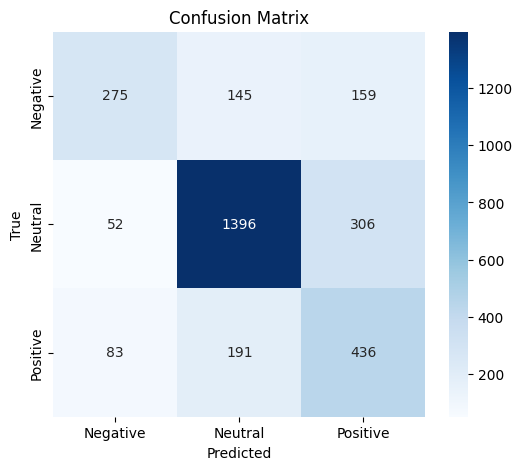

Accuracy : 0.6924088070982582
F1 Score : 0.693759412374801
Precision: 0.7051132326764562
Recall   : 0.6924088070982582


In [17]:
# Predict on validation set
preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=-1)
labels = preds_output.label_ids

# Confusion matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'],
            yticklabels=['Negative','Neutral','Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print precision, recall, f1, accuracy
print("Accuracy :", accuracy_score(labels, preds))
print("F1 Score :", f1_score(labels, preds, average='weighted'))
print("Precision:", precision_score(labels, preds, average='weighted'))
print("Recall   :", recall_score(labels, preds, average='weighted'))


              precision    recall  f1-score   support

    Positive       0.67      0.47      0.56       579
    Negative       0.81      0.80      0.80      1754
     Neutral       0.48      0.61      0.54       710

    accuracy                           0.69      3043
   macro avg       0.65      0.63      0.63      3043
weighted avg       0.71      0.69      0.69      3043



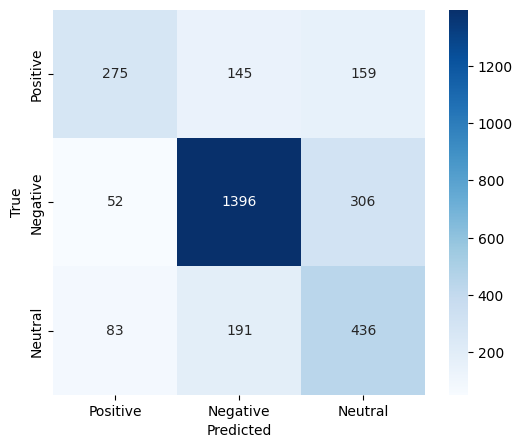

In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
preds = trainer.predict(val_dataset)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names=["Positive","Negative","Neutral"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positive","Negative","Neutral"], yticklabels=["Positive","Negative","Neutral"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
